In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.decomposition import PCA

## Feature Extraction

### Local Binary Pattern

In [2]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' 
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1790, 256, 256)
(1432, 256, 256)
(358, 256, 256)
(1432,)
(358,)


In [3]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.9189944134078212
Test Accuracy: 0.8435754189944135
Precision: 0.8452380952380952
Recall: 0.8402986947791165
F1 Score: 0.8417929292929293

Overall Accuracy:               precision    recall  f1-score   support

           0       0.83      0.89      0.86       192
           1       0.86      0.80      0.82       166

    accuracy                           0.84       358
   macro avg       0.85      0.84      0.84       358
weighted avg       0.84      0.84      0.84       358

Test Accuracy: 84.36%


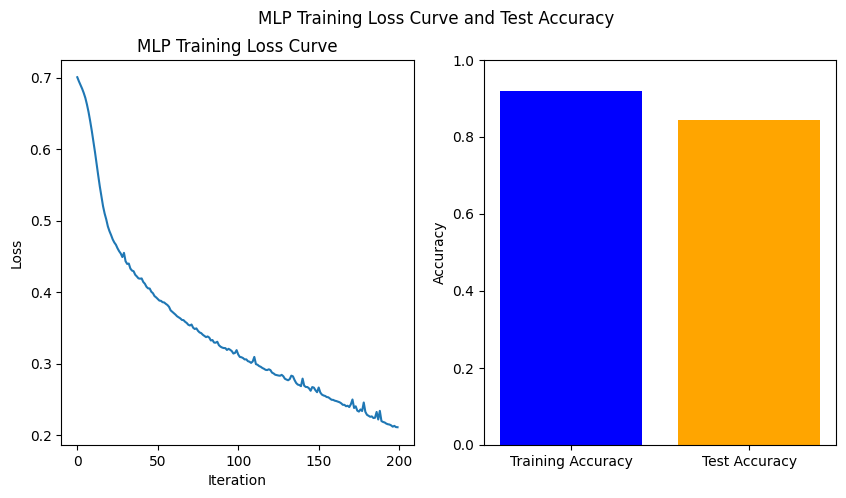

In [4]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"\nOverall Accuracy: {classify_report}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp.score(X_train, y_train), mlp.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('LBP_mlp_training_curve.png')

plt.show()

In [5]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl
